## Introduction
The issue of keeping one's employees happy and satisfied is a perennial and age-old challenge. If an employee you have invested so much time and money leaves for "greener pastures", then this would mean that you would have to spend even more time and money to hire somebody else. In the spirit of Kaggle, let us therefore turn to our predictive modelling capabilities and see if we can predict employee attrition on this synthetically generated IBM dataset.

This notebook is structured as follows:

**Exploratory Data Analysis :** In this section, we explore the dataset by taking a look at the feature distributions, how correlated one feature is to the other and create some Seaborn and Plotly visualisations. <br>
**Feature Engineering and Categorical Encoding :** Conduct some feature engineering as well as encode all our categorical features into dummy variables.<br>
**Implementing Machine Learning models :** We implement a Random Forest and a Gradient Boosted Model after which we look at feature importances from these respective models

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Hr_data.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Checking for null values
display(data.isnull().any())

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [4]:
#Checking for datatypes
data.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [5]:
#Attrition based on Age

age_att=data.groupby(['Age','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.line(age_att,x='Age',y='Counts',color='Attrition',title='Agewise Counts of People in an Organization')

**Observation:** As seen in the chart above, the attrition is maximum between the age groups 28-32. The attrition rate keeps on falling with increasing age, as people look after stability in their jobs at these point of times. Also at a very younger age, i.e. from 18-20, the chances of an employee leaving the organization is far more- since they are exploring at that point of time. It reaches a break even point at the age of 21

In [6]:
#Income affecting attrition

rate_att=data.groupby(['MonthlyIncome','Attrition']).apply(lambda x:x['MonthlyIncome'].count()).reset_index(name='Counts')
rate_att['MonthlyIncome']=round(rate_att['MonthlyIncome'],-3)
rate_att=rate_att.groupby(['MonthlyIncome','Attrition']).apply(lambda x:x['MonthlyIncome'].count()).reset_index(name='Counts')
fig=px.line(rate_att,x='MonthlyIncome',y='Counts',color='Attrition',title='Monthly Income basis counts of People in an Organization')
fig.show()

**Observation:** As seen in the above chart, the attrition rate is evidently high at very low income levels- less than 5k monthly. This decreases further- but a minor spike is noticed aorund 10k- indicating the middle class liveliood. They tend to shift towards a better standard of living, and hence move to a different job. When the monthly income is pretty decent, the chances of an employee leaving the organization is low- as seen by the flat line

In [7]:
#Attrition based on Job Satisfaction

jsats_att=data.groupby(['JobSatisfaction','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.area(jsats_att,x='JobSatisfaction',y='Counts',color='Attrition',title='Job Satisfaction level Counts of People in an Organization')

**Observation:** With an increasing job satisfaction, the attrition rates decrease as can be seen in the chart above. Also from range 1-2 range we can infer (as seen above in Environment Satisfaction), the attrition level falls, but raises from 2-3, where the people tend to coose better opportunities.

In [8]:
#How managers can impact attrition


man_att=data.groupby(['YearsWithCurrManager','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.line(man_att,x='YearsWithCurrManager',y='Counts',color='Attrition',title='Count of people spending years with a Manager in an Organization')

**Observation:** We notice 3 major spikes in the attrition rate, when we are analyzing the relationship of an employee with their manager. At the very start, where the time spent with the manager is relatively less- people tend to leave their jobs- considering their relationship with their previous managers. At an average span of 2 years, when employees feel they need an improvement, they also tend to go for a change. When the time spent with the manager is slightly higher (about 7 years)- people tend to find their career progression stagnant, and tend to go for a change. But when the relative time spend with a manager is very high- people are satisfied with their work. Hence the chances of an employee resigning then is significantly low.

In [9]:
#Attrition based on Experience 


ncwrd_att=data.groupby(['NumCompaniesWorked','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.area(ncwrd_att,x='NumCompaniesWorked',y='Counts',color='Attrition',title='Work Experience level Counts of People in an Organization')

**Observations:** As seen from the chart above, clearly, employees who started their career with the company- or have switched to the company in the initial years of their career, have a higher chances of leaving the organization to a different company. People who have gained much experience- working in multiple companies tend to stay in the company they join.

In [10]:
#Work life balance impact on attrition




wlb_att=data.groupby(['WorkLifeBalance','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.bar(wlb_att,x='WorkLifeBalance',y='Counts',color='Attrition',title='Work Life Balance level Counts of People in an Organization')

**Observation:** People with poor levels of Work life balance have adjusted themselves to their jobs, but as seen for the above parameters with a better work life score, people are more accustomed to the better life and want to go for an attrition more. But this trend perishes when the work life balance is really good, and people are satisfied with the work they are doing

In [11]:
#How company stocks affects attrition


stock_att=data.groupby(['StockOptionLevel','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.bar(stock_att,x='StockOptionLevel',y='Counts',color='Attrition',title='Stock facilities level wise People in an Organization')

**Observation:** The tendency of employees to leave the organization is much more when the stock availing options are limited. Since the stocks constitute to a huge amount of money while staying for a few years, people do not want to lose that opportunity. People with very limited/no stcok options have a freedom to leave the organization at will.

In [12]:
#Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}

data["Attrition_numerical"] = data["Attrition"].apply(lambda x: target_map[x])

**Correlation of Features**
The next tool in a data explorer's arsenal is that of a correlation matrix. By plotting a correlation matrix, we have a very nice overview of how the features are related to one another. For a Pandas dataframe, we can conveniently use the call .corr which by default provides the Pearson Correlation values of the columns pairwise in that dataframe.

In this correlation plot, I will use the the Plotly library to produce a interactive Pearson correlation matrix via the Heatmap function as follows:

In [13]:
# creating a list of only numerical values
numerical = [u'Age', u'DailyRate', u'DistanceFromHome', 
             u'Education', u'EmployeeNumber', u'EnvironmentSatisfaction',
             u'HourlyRate', u'JobInvolvement', u'JobLevel', u'JobSatisfaction',
             u'MonthlyIncome', u'MonthlyRate', u'NumCompaniesWorked',
             u'PercentSalaryHike', u'PerformanceRating', u'RelationshipSatisfaction',
             u'StockOptionLevel', u'TotalWorkingYears',
             u'TrainingTimesLastYear', u'WorkLifeBalance', u'YearsAtCompany',
             u'YearsInCurrentRole', u'YearsSinceLastPromotion',u'YearsWithCurrManager']
corr_data = [
    go.Heatmap(
        z= data[numerical].astype(float).corr().values, # Generating the Pearson correlation
        x=data[numerical].columns.values,
        y=data[numerical].columns.values,
        colorscale='Viridis',
        reversescale = False,
#         text = True ,
        opacity = 1.0
        
    )
]


layout = go.Layout(
    title='Pearson Correlation of numerical features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)


fig = go.Figure(data=corr_data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

**Pairplot Visualisations**
Now let us create some Seaborn pairplots and set it against the target variable which is our Attrition column to get a feel for how the various features are distributed vis-a-vis employee attrition

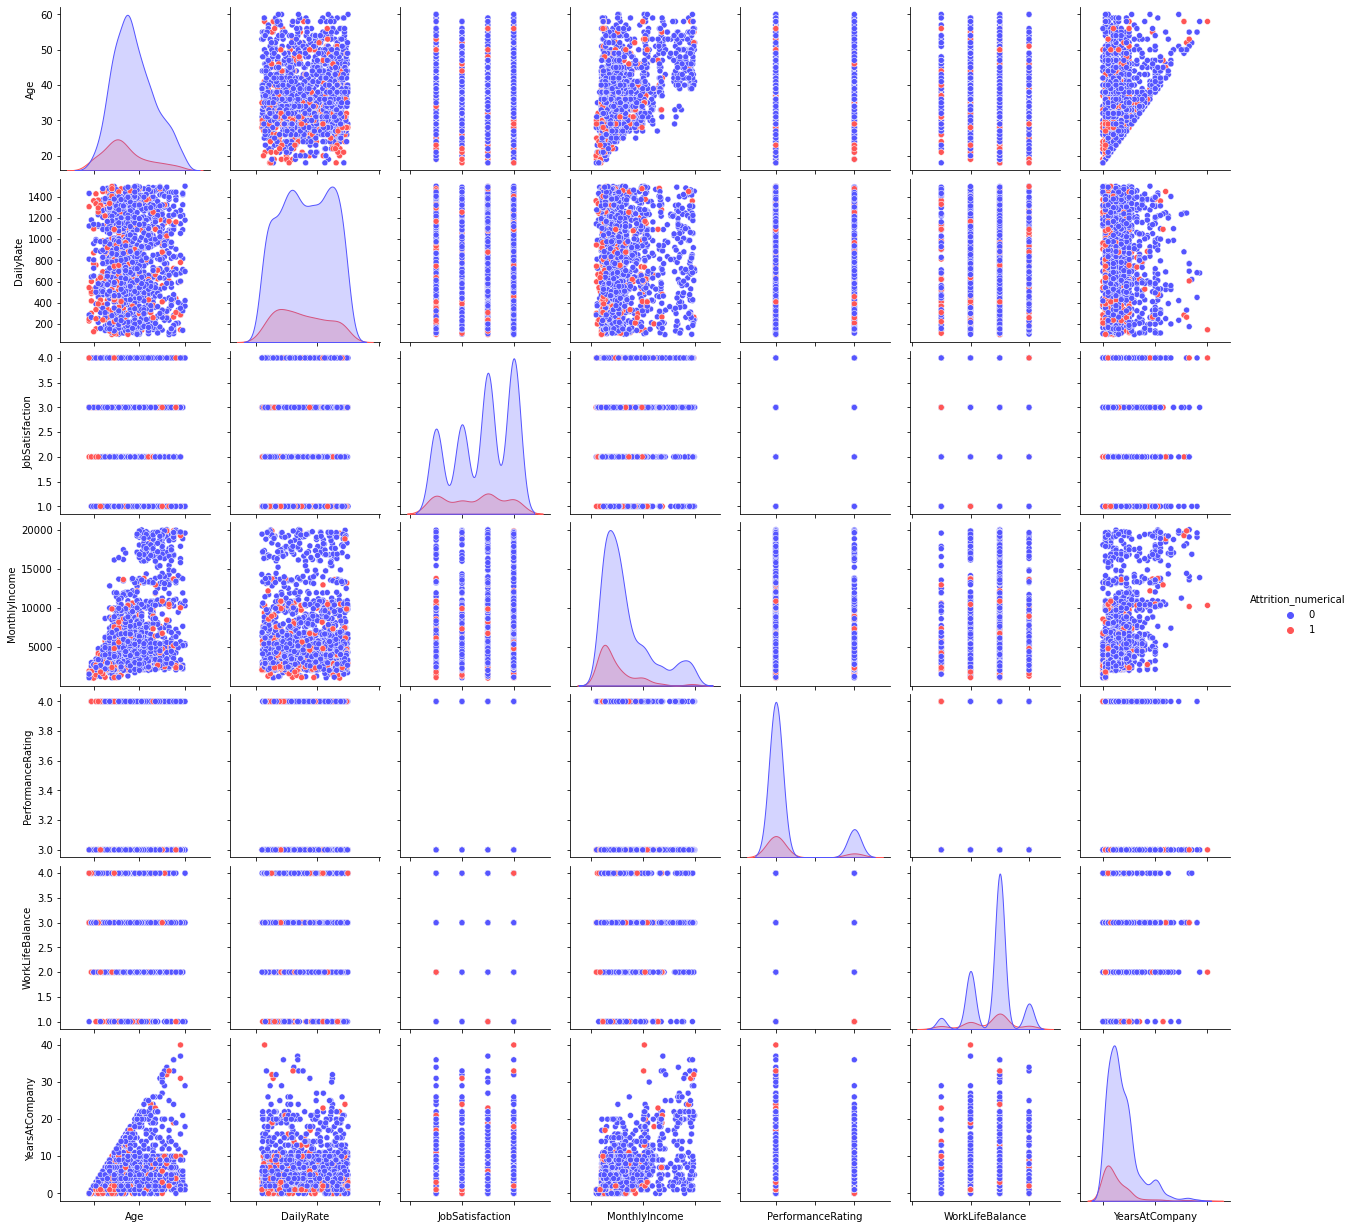

In [14]:
# Refining our list of numerical variables
numerical = [u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']

g = sns.pairplot(data[numerical], hue='Attrition_numerical', palette='seismic', diag_kind = 'kde',diag_kws=dict(shade=True))
g.set(xticklabels=[])

## 2. Feature Engineering & Categorical Encoding

Having carried out a brief exploration into the dataset, let us now proceed onto the task of Feature engineering and numerically encoding the categorical values in our dataset. Feature engineering in a nutshell involves creating new features and relationships from the current features that we have. Feature engineering has been quite

To start off, we shall segregate numerical columns from categorical columns via the use of the dtype method as follows:

In [15]:
# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
data = data.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in data.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = data.columns.difference(categorical)
categorical

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

Having identified which of our features contain categorical data, we can set about numerically encoding the data. To do this, I shall use the get_dummies method from Pandas which creates encoded dummy variables from the categorical variables.

In [16]:
# Store the categorical data in a dataframe called attrition_cat
data_cat = data[categorical]
data_cat = data_cat.drop(['Attrition'], axis=1) # Dropping the target column
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   BusinessTravel  1470 non-null   object
 1   Department      1470 non-null   object
 2   EducationField  1470 non-null   object
 3   Gender          1470 non-null   object
 4   JobRole         1470 non-null   object
 5   MaritalStatus   1470 non-null   object
 6   Over18          1470 non-null   object
 7   OverTime        1470 non-null   object
dtypes: object(8)
memory usage: 92.0+ KB


Applying the **get_dummies method**, we see that we have encoded our categorical values conveniently by just applying one line of Python code.

In [17]:
data_cat = pd.get_dummies(data_cat)
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   BusinessTravel_Non-Travel          1470 non-null   uint8
 1   BusinessTravel_Travel_Frequently   1470 non-null   uint8
 2   BusinessTravel_Travel_Rarely       1470 non-null   uint8
 3   Department_Human Resources         1470 non-null   uint8
 4   Department_Research & Development  1470 non-null   uint8
 5   Department_Sales                   1470 non-null   uint8
 6   EducationField_Human Resources     1470 non-null   uint8
 7   EducationField_Life Sciences       1470 non-null   uint8
 8   EducationField_Marketing           1470 non-null   uint8
 9   EducationField_Medical             1470 non-null   uint8
 10  EducationField_Other               1470 non-null   uint8
 11  EducationField_Technical Degree    1470 non-null   uint8
 12  Gender_Female       

**Creating new features from Numerical data**

In [18]:
# Store the numerical features to a dataframe attrition_num
data_num = data[numerical]
data_num

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,1,1,2,94,3,2,...,1,80,0,8,0,1,6,4,0,5
1,49,279,8,1,1,2,3,61,2,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1373,2,2,1,4,4,92,2,1,...,2,80,0,7,3,3,0,0,0,0
3,33,1392,3,4,1,5,4,56,3,1,...,3,80,0,8,3,3,8,7,3,0
4,27,591,2,1,1,7,1,40,3,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,1,2061,3,41,4,2,...,3,80,1,17,3,3,5,2,0,3
1466,39,613,6,1,1,2062,4,42,2,3,...,1,80,1,9,5,3,7,7,1,7
1467,27,155,4,3,1,2064,2,87,4,2,...,2,80,1,6,0,3,6,2,0,3
1468,49,1023,2,3,1,2065,4,63,2,2,...,4,80,0,17,3,2,9,6,0,8


Having encoded our categorical columns as well as engineering and created some new features from the numerical data, we can now proceed to merging both dataframes into a final set with which we will train and test our models on.

In [19]:
# Concat the two dataframes together columnwise
data_final = pd.concat([data_num, data_cat], axis=1)

In [20]:
data_cat.info()
data_cat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   BusinessTravel_Non-Travel          1470 non-null   uint8
 1   BusinessTravel_Travel_Frequently   1470 non-null   uint8
 2   BusinessTravel_Travel_Rarely       1470 non-null   uint8
 3   Department_Human Resources         1470 non-null   uint8
 4   Department_Research & Development  1470 non-null   uint8
 5   Department_Sales                   1470 non-null   uint8
 6   EducationField_Human Resources     1470 non-null   uint8
 7   EducationField_Life Sciences       1470 non-null   uint8
 8   EducationField_Marketing           1470 non-null   uint8
 9   EducationField_Medical             1470 non-null   uint8
 10  EducationField_Other               1470 non-null   uint8
 11  EducationField_Technical Degree    1470 non-null   uint8
 12  Gender_Female       

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
1466,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
1467,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
1468,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,1,1,0


In [21]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   DailyRate                          1470 non-null   int64
 2   DistanceFromHome                   1470 non-null   int64
 3   Education                          1470 non-null   int64
 4   EmployeeCount                      1470 non-null   int64
 5   EmployeeNumber                     1470 non-null   int64
 6   EnvironmentSatisfaction            1470 non-null   int64
 7   HourlyRate                         1470 non-null   int64
 8   JobInvolvement                     1470 non-null   int64
 9   JobLevel                           1470 non-null   int64
 10  JobSatisfaction                    1470 non-null   int64
 11  MonthlyIncome                      1470 non-null   int64
 12  MonthlyRate         

**Target variable**

One final step that that we have to remember is to generate our target variable. The target in this case is given by the column **Attrition** which contains categorical variables therefore requires numerical encoding. We numerically encode it by creating a dictionary with the mapping given as 1 : Yes and 0 : No

In [22]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = data["Attrition"].apply(lambda x: target_map[x])
target.head(6)

0    1
1    0
2    1
3    0
4    0
5    0
Name: Attrition, dtype: int64

However just by a quick inspection of the counts of the number of 'Yes' and 'No' in the target variable tells us that there is quite a large skew in target as shown

In [23]:
data_attr = [go.Bar(
            x=data["Attrition"].value_counts().index.values,
            y= data["Attrition"].value_counts().values
    )]

py.iplot(data_attr, filename='basic-bar')

Therefore we have to keep in mind that there is quite a big imbalance in our target variable. Many statistical techniques have been put forth to treat imbalances in data (oversampling or undersampling). In this notebook, I will use an oversampling technique known as SMOTE to treat this imbalance.

## 3. Implementing Machine Learning Models

Having performed some exploratory data analysis and simple feature engineering as well as having ensured that all categorical values are encoded, we are now ready to proceed onto building our models.

As alluded to in the introduction of this notebook, we will aim to evaluate and contrast the performances of a handful of different learning models.

**Splitting Data into Train and Test sets**

But before we even start training a model, we will have to partition our dataset into a training set and a test set (unlike Kaggle competitions where the train and test data are already segregated for you). To split our data we will utilise sklearn's

In [24]:
# Import the train_test_split method
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_val = train_test_split(data_final, 
                                                         target, 
                                                         train_size= 0.80,
                                                         random_state=0);
#train, test, target_train, target_val = StratifiedShuffleSplit(attrition_final, target, random_state=0);

In [25]:
target_train

1374    0
1092    0
768     0
569     0
911     1
       ..
763     0
835     0
1216    0
559     0
684     0
Name: Attrition, Length: 1176, dtype: int64

**SMOTE to oversample due to the skewness in target**

Since we have already noted the severe imbalance in the values within the target variable, let us implement the SMOTE method in the dealing with this skewed value via the imblearn Python package.

In [26]:
from imblearn.over_sampling import SMOTE

oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_resample(train,target_train)

In [27]:
smote_target.value_counts()

0    988
1    988
Name: Attrition, dtype: int64

<AxesSubplot:>

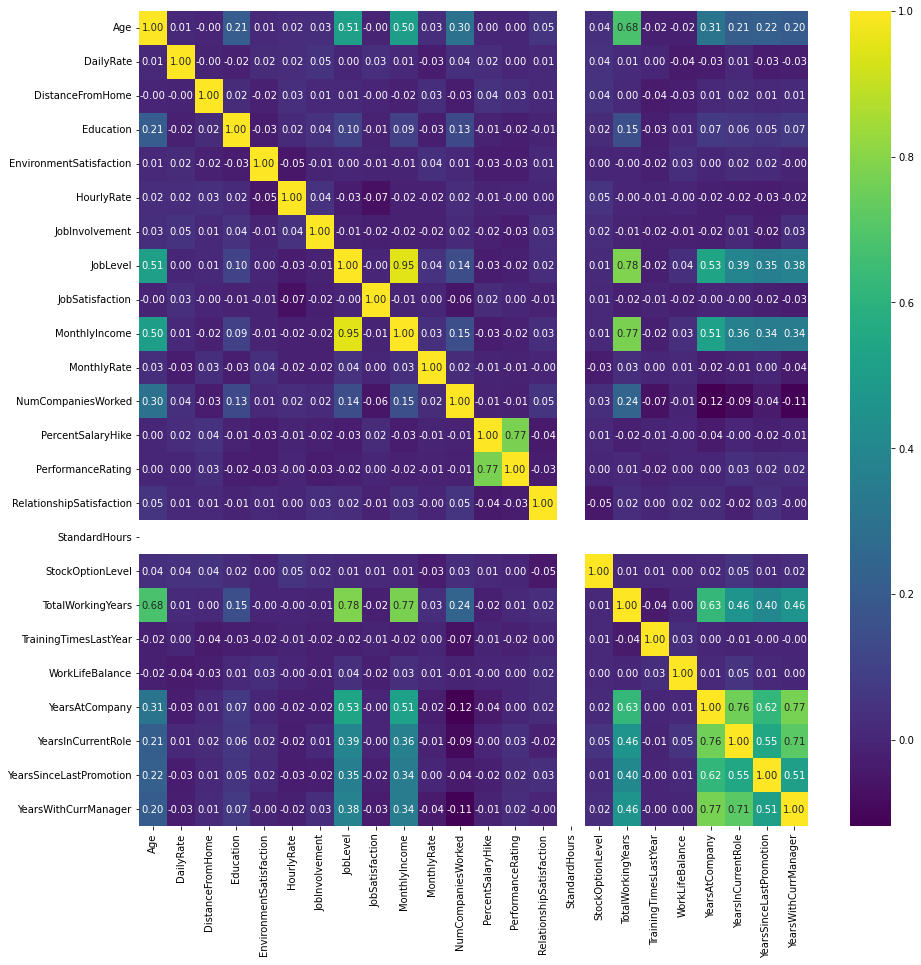

In [28]:
X=data[['Age', 'DailyRate',
       'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction',
        'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction','StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']]
y=data[['Attrition']].values.ravel()
plt.figure(figsize=(15,15))
sns.heatmap(X.corr(),annot=True,fmt='.2f',cmap='viridis')

In [29]:
log_reg = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=True)


log_reg.fit(smote_train, smote_target)

print('--------------------------------------------------------------------------')
print('Logistic Regression:')
print('Traning Model accruracy scores: {:.3f}'.format(log_reg.score(smote_train, smote_target)))
print('Test Model accruracy scores: {:.3f}'.format(log_reg.score(smote_train, smote_target)))
print('--------------------------------------------------------------------------')

--------------------------------------------------------------------------
Logistic Regression:
Traning Model accruracy scores: 0.899
Test Model accruracy scores: 0.899
--------------------------------------------------------------------------


## A. Random Forest Classifier
The Random Forest method, first introduced by Breiman in 2001 can be grouped under the category of ensemble models. Why ensemble? The building block of a Random Forest is the ubiquitous Decision Tree. The decision tree as a standalone model is often considered a "weak learner" as its predictive performance is relatively poor. However a Random Forest gathers a group (or ensemble) of decision trees and uses their combined predictive capabilities to obtain relatively strong predictive performance - "strong learner".

This principle of using a collection of "weak learners" to come together to create a "strong learner" underpins the basis of ensemble methods which one regularly comes across in Machine learning. For a really good read that drives home the basics of the Random Forest, refer to this CitizenNet blog

**Initialising Random Forest parameters**

We will utilise the Scikit-learn library to construct a Random Forest model. To do so, we have to first define our set of parameters that we will feed into our Random Forest classifier as follows

In [30]:
seed = 0   # We set our random seed to zero for reproducibility
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
#     'warm_start': True, 
    'max_features': 0.3,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}


Having defined our parameters, we can initialise a Random Forest object by using scikit-learn's **RandomForestClassifier** and unpacking the parameters by adding the double asterisks symbols as follows

In [31]:
rf = RandomForestClassifier(**rf_params)

The next step after prepping our Random Forest model would be to start building a forest of trees using our training set and fitting it to our attrition target variable. We do so by simply using the **fit** call as follows

In [32]:
rf.fit(smote_train, smote_target)
print("Fitting of Random Forest finished")

Fitting of Random Forest finished


Having fitted our forest of trees with our parameters to the training set against our target variable, we now have a learning model **rf** which we can make predictions out of. To use our Random Forest in predicting against our test data, we can use sklearn's **.predict** method as follows

In [33]:
rf_predictions = rf.predict(test)
print("Predictions finished")

Predictions finished


Scoring the model

In [34]:
print("Accuracy score: {}".format(accuracy_score(target_val, rf_predictions)))
print("="*80)
print(classification_report(target_val, rf_predictions))

Accuracy score: 0.8537414965986394
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       245
           1       0.57      0.49      0.53        49

    accuracy                           0.85       294
   macro avg       0.74      0.71      0.72       294
weighted avg       0.85      0.85      0.85       294



**Accuracy of the model**

As observed, our Random Forest returns an accuracy of approx 88% for its predictions and on first glance this might seem to be a pretty good performing model. However when we think about how skewed our target variable where the distribution of yes and no's are 84% and 26%, therefore our model is only predicting slightly better than random guessing.

It would be more informative to balance out the precision and recall scores as show in the classification report outputs. Where it falls down to the business considerations over whether one should prioritise for a metric over the other - i.e. your Precision vs Recall.

**Feature Ranking via the Random Forest**<br>
The Random Forest classifier in Sklearn also contains a very convenient attribute feature_importances_ which tells us which features within our dataset has been given most importance through the Random Forest algorithm. Shown below is an Interactive Plotly diagram of the various feature importances.

In [35]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = data_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = data_final.columns.values
)
data_rf = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data_rf, layout=layout)
py.iplot(fig,filename='scatter2010')

## B. Gradient Boosted Classifier
Gradient Boosting is also an ensemble technique much like the Random Forest where a combination of weak Tree learners are brought together to form a relatively stronger learner. The technique involves defining some sort of function (loss function) that you want minimised and an method/algorithm to minimise this. Therefore as the name suggests, the algorithm used to minimise the loss function is that of a gradient descent method which adds decision trees which "point" in the direction that reduces our loss function (downward gradient).

To set up a Gradient Boosting classifier is easy enough in Sklearn and it involves only a handful of lines of code. Again we first set up our classifier's parameters

**Initialising Gradient Boosting Parameters**

In general there are a handful of key parameter when setting up tree-based or gradient boosted models. These are always going to be the number of estimators, the maximum depth with which you want your model to be trained to, and the minimum samples per leaf

In [36]:
# Gradient Boosting Parameters
gb_params ={
    'n_estimators': 1500,
    'max_features': 0.9,
    'learning_rate' : 0.25,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

Having defined our parameters, we can now apply the usual fit and predict methods on our train and test sets respectively

In [37]:
gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTEd train and target
gb.fit(smote_train, smote_target)
# Get our predictions
gb_predictions = gb.predict(test)
print("Predictions have finished")

Predictions have finished


In [38]:
print(accuracy_score(target_val, gb_predictions))
print(classification_report(target_val, gb_predictions))

0.8537414965986394
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       245
           1       0.61      0.35      0.44        49

    accuracy                           0.85       294
   macro avg       0.74      0.65      0.68       294
weighted avg       0.83      0.85      0.84       294



**Feature Ranking via the Gradient Boosting Model**<br>
Much like the Random Forest, we can invoke the feature_importances_ attribute of the gradient boosting model and dump it in an interactive Plotly chart

In [39]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = data_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = data_final.columns.values
)
data_gb = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data_gb, layout=layout)
py.iplot(fig,filename='scatter')

## CONCLUSION
We have constructed a very simple pipeline of predicting employee attrition, from some basic Exploratory Data Analysis to feature engineering as well as implementing two learning models in the form of a Random Forest and a Gradient Boosting classifier. This whole notebook takes less than a minute to run and it even returns a 89% accuracy in its predictions.

That being said, there is quite a lot of room for improvement. For one, more features could be engineered from the data. Furthermore one could squeeze performance out of this pipeline by perhaps using some form of blending or stacking of models. I myself am quite keen to implement a classifier voting where a handful of classifiers votes on the outcome of the predictions and we take the majority vote.